#  第3章 k近邻法

1．$k$近邻法是基本且简单的分类与回归方法。$k$近邻法的基本做法是：对给定的训练实例点和输入实例点，首先确定输入实例点的$k$个最近邻训练实例点，然后利用这$k$个训练实例点的类的多数来预测输入实例点的类。

2．$k$近邻模型对应于基于训练数据集对特征空间的一个划分。$k$近邻法中，当训练集、距离度量、$k$值及分类决策规则确定后，其结果唯一确定。

3．$k$近邻法三要素：距离度量、$k$值的选择和分类决策规则。常用的距离度量是欧氏距离及更一般的**pL**距离。$k$值小时，$k$近邻模型更复杂；$k$值大时，$k$近邻模型更简单。$k$值的选择反映了对近似误差与估计误差之间的权衡，通常由交叉验证选择最优的$k$。

常用的分类决策规则是多数表决，对应于经验风险最小化。

4．$k$近邻法的实现需要考虑如何快速搜索k个最近邻点。**kd**树是一种便于对k维空间中的数据进行快速检索的数据结构。kd树是二叉树，表示对$k$维空间的一个划分，其每个结点对应于$k$维空间划分中的一个超矩形区域。利用**kd**树可以省去对大部分数据点的搜索， 从而减少搜索的计算量。

### 距离度量

设特征空间$x$是$n$维实数向量空间 ，$x_{i}, x_{j} \in \mathcal{X}$,$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(n)}\right)^{\mathrm{T}}$,$x_{j}=\left(x_{j}^{(1)}, x_{j}^{(2)}, \cdots, x_{j}^{(n)}\right)^{\mathrm{T}}$
，则：$x_i$,$x_j$的$L_p$距离定义为:


$L_{p}\left(x_{i}, x_{j}\right)=\left(\sum_{i=1}^{n}\left|x_{i}^{(i)}-x_{j}^{(l)}\right|^{p}\right)^{\frac{1}{p}}$

- $p= 1$  曼哈顿距离
- $p= 2$  欧氏距离
- $p= \infty$   切比雪夫距离

In [32]:
import math # 导入数学库
from itertools import combinations  # 用于操作迭代对象

In [33]:
def L(x, y, p=2):   # 定义距离计算函数，p = 2 对应上文欧式距离
    # x1 = [1, 1], x2 = [5,1]
    if len(x) == len(y) and len(x) > 1: # 判断向量维度是否相等
        sum = 0 # 存储累加数据
        for i in range(len(x)): # 循环迭代 0 到 len(x)-1
            sum += math.pow(abs(x[i] - y[i]), p)    # pow() 次方计算
        return math.pow(sum, 1 / p) # 返回x与y的欧式距离
    else:
        return 0

### 课本例3.1

In [34]:
x1 = [1, 1]
x2 = [5, 1]
x3 = [4, 4]

In [35]:
# x1, x2
# 计算 x1与x2,x3的距离，并打印其中最小的一组
for i in range(1, 5):   # 迭代，下标 1 至 4
    r = {'1-{}'.format(c): L(x1, c, p=i) for c in [x2, x3]} # 创建字典，
    # for c in [x2, x3]:
    #   x_len = L(x1, c, p=i)
    #   x_str = '1-{}'.format(c)
    #   r.update({x_str : x_len})
    
    # min()函数功能为取传入的多个参数中的最小值，或者传入的可迭代对象元素中的最小值。
    # zip()接受任意多个序列作为参数，将所有序列按相同的索引组合成一个元素是各个序列合并成的tuple的新序列，新的序列的长度以参数中最短的序列为准。另外(*)操作符与zip函数配合可以实现与zip相反的功能，即将合并的序列拆成多个tuple。
    # print(r)
    # zip_data = zip(r.values(), r.keys())
    # for data in zip_data:
	#     print(list(data))
    print(min(zip(r.values(), r.keys())))   # 将数据组合为tuple,并打印其中最小的一组

(4.0, '1-[5, 1]')
(4.0, '1-[5, 1]')
(3.7797631496846193, '1-[4, 4]')
(3.5676213450081633, '1-[4, 4]')


python实现，遍历所有数据点，找出$n$个距离最近的点的分类情况，少数服从多数

In [36]:
import numpy as np  # numpy:Python中基于数组对象的科学计算库，支持大量的维度数组与矩阵运算，以及大量的数学函数库。
import pandas as pd # 基于numpy,用于处理文本或者表格数据
import matplotlib.pyplot as plt # # 绘图函数
%matplotlib inline

from sklearn.datasets import load_iris  # 鸢尾花数据集,包含了3类鸢尾花的4个特征（萼片长度、萼片宽度、花瓣长度、花瓣宽度），共有150个样本。
from sklearn.model_selection import train_test_split    # 导入数据切分：train_test_split函数
# sklearn中模型选择model_selection模块常用函数的使用。包括：    
# 1. 数据切分：train_test_split() 其输入为待切分的特征X 和 相应变量y。输出按顺序为：切分后的训练集特征X_train，测试集特征X_test，训练集响应变量y_train，测试集响应变量y_test。
# 2. K折交叉验证：KFold,StratifiedKFold,cross_val_score
# 3. 参数网格搜索：GridSearchCV
from collections import Counter # 导入counter()函数，可以用来统计一个 python 列表、字符串、元组等可迭代对象中每个元素出现的次数，并返回一个字典。

In [37]:
# data
iris = load_iris()  # 加载数据集
# 创建一个 DataFrame 对象：二维表格型数据，含有一组有序的列，每列可以是不同的值类型。既有行索引，也有列索引。
# 将iris.data作为数据源，iris.feature_name(特征名称 每列的属性名，['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] ）作为列名。
# print(iris.feature_names)
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target   # iris.target:目标属性，品种信息；将此值赋值给df的lable
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
# data = np.array(df.iloc[:100, [0, 1, -1]])

In [38]:
df  # 将此DataFrame类型数据输出

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


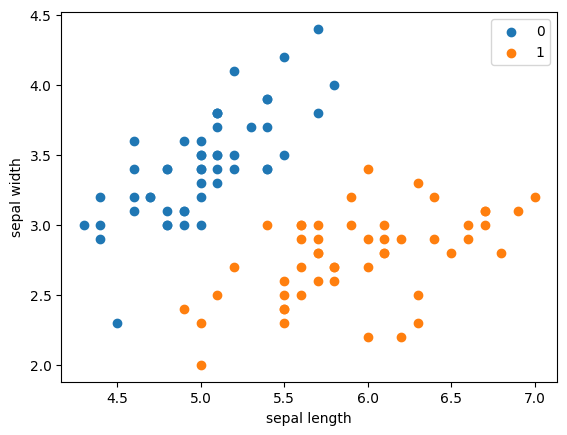

In [39]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0') # 绘制散点图
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')   # 绘制散点图
plt.xlabel('sepal length')  # X轴标签
plt.ylabel('sepal width')    # Y轴标签
plt.legend()    # 添加图例，下图中的 0 1  

In [40]:
# iloc:通过索引行、列的索引位置[index, columns]来寻找值
data = np.array(df.iloc[:100, [0, 1, -1]])  # 选取前100行;0列，1列和-1(最后一列)；即'sepal length', 'sepal width'--萼片长度、萼片宽度，-1为lable,即类型标记
X, y = data[:,:-1], data[:,-1]  # 选取除了最后一列之外的所有列变量作为X变量；选取最后一列列变量作为y变量
# train_test_split() 其输入为待切分的特征X 和 相应变量y。输出按顺序为：切分后的训练集特征X_train，测试集特征X_test，训练集响应变量y_train，测试集响应变量y_test。
# train_test_split 函数参数说明：
#   train_size：指定训练集大小（整数）/训练集比例（小数）
#   test_size：指定测试集大小（整数）/测试集比例（小数）
#   shuffle：默认值为True，表示在进行数据分割前，先进行数据打乱重排。
#   random_state：随机种子，用来保证每次运行函数时，数据打乱重排的结果是一致的。
#   stratify：用于控对制数据按标签类别进行分层切分。默认值为None，表示随机划分标签。当给定一个array时，将对array中的每个类别按相同的比例切分，此时其取值通常为类别响应变量y。（后面将通过具体实例进行演示）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
class KNN:  # 定义模型类
    def __init__(self, X_train, y_train, n_neighbors=3, p=2):   # 初始化数据，n_neighbors:临近点个数，默认值为3 ; p:距离度量,默认为2,欧氏距离
        """
        parameter: n_neighbors 临近点个数
        parameter: p 距离度量
        """
        self.n = n_neighbors    # 临近点个数
        self.p = p      # 距离向量
        self.X_train = X_train  # 特征
        self.y_train = y_train  # 标记

    def predict(self, X):   # 预测
        # 取出n个点
        # 取距离最小的k个点：先取前k个，然后遍历替换
        # 取出n个点，放入空的列表，列表中存放预测点与训练集点的距离及其对应标签
        knn_list = []   # knn_list存“距离”和“label”
        for i in range(self.n):
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)  # 求范数，范数通常用来衡量一个向量或者矩阵的大小。
            knn_list.append((dist, self.y_train[i]))    # 将求得的范数（“距离”）和 lable

        # 再取出训练集剩下的点，然后与n_neighbor个点比较大叫，将距离大的点更新
        # 保证knn_list列表中的点是距离最小的点
        for i in range(self.n, len(self.X_train)):
            # lambda [parameter_list] : expression
            # lambda 表达式必须使用 lambda 关键字定义。
            # lambda匿名函数的格式:在lambda关键字之后、冒号左边为参数列表，可不带参数，也可有多个参数。若有多个参数，则参数间用逗号隔开；冒号右边的为表达式，其实lambda返回值是一个函数的地址，也就是函数对象。
            max_index = knn_list.index(max(knn_list, key=lambda x: x[0])) # 找出knn_list “距离” 最大的数据，并返回其下标
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)  # 计算第 i 个数据的范数，即欧式距离
            if knn_list[max_index][0] > dist:   # 如果knn_list当前的距离最大值比第i个距离大
                knn_list[max_index] = (dist, self.y_train[i])   # 将knn_list当前的最大值替换为第i个

        # 统计
        knn = [k[-1] for k in knn_list] # knn存储knn_list中最后一行，即lable数据
        count_pairs = Counter(knn)  # counter为计数器，按照标签计数,并返回字典数据类型 {值:个数}
#         max_count = sorted(count_pairs, key=lambda x: x)[-1]
        max_count = sorted(count_pairs.items(), key=lambda x: x[1])[-1][0]  # 排序,并返回个数最多的lable
        return max_count

    def score(self, X_test, y_test):    # 求预测的正确率
        right_count = 0
        n = 10
        for X, y in zip(X_test, y_test):     # zip()将数据组合为tuple
            label = self.predict(X)         # 进行预测
            if label == y:  # 如果分类正确
                right_count += 1    # 正确数+1
        return right_count / len(X_test)    # 正确率，分类正确数/总数

In [42]:
clf = KNN(X_train, y_train)   # 调用knn算法进行计算

In [43]:
clf.score(X_test, y_test)   # 计算正确率

1.0

In [44]:
test_point = [6.0, 3.0] # 测试点
print('Test Point: {}'.format(clf.predict(test_point))) # 测试点预测结果

Test Point: 1.0


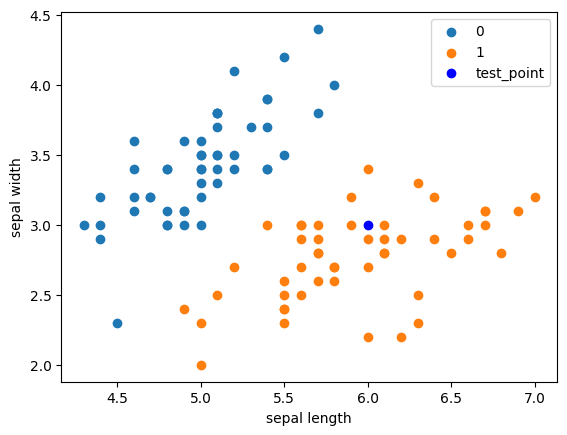

In [45]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0') # 绘制lable= '0'的散点图
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')   # 绘制lable= '1'的散点图
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')    # 绘制测试点
plt.xlabel('sepal length')  # X轴标签
plt.ylabel('sepal width')   # Y轴标签
plt.legend()    # 添加图例

### scikit-learn实例

In [46]:
# 导入KNeighborsClassifier：sklearn.neighbors.KNeighborsClassifier()函数用于实现k-近邻算法（k-Nearest Neighbour algorithm）的分类器
from sklearn.neighbors import KNeighborsClassifier

In [47]:
clf_sk = KNeighborsClassifier()
clf_sk.fit(X_train, y_train)    # 使用X作为训练数据，y作为目标值（类似于标签）来拟合模型

KNeighborsClassifier()

In [48]:
clf_sk.score(X_test, y_test)    # 在测试集中分类并计算正确率

1.0

### sklearn.neighbors.KNeighborsClassifier

- n_neighbors: 临近点个数
- p: 距离度量
- algorithm: 近邻算法，可选{'auto', 'ball_tree', 'kd_tree', 'brute'}
- weights: 确定近邻的权重

### kd树

**kd**树是一种对k维空间中的实例点进行存储以便对其进行快速检索的树形数据结构。

**kd**树是二叉树，表示对$k$维空间的一个划分（partition）。构造**kd**树相当于不断地用垂直于坐标轴的超平面将$k$维空间切分，构成一系列的k维超矩形区域。kd树的每个结点对应于一个$k$维超矩形区域。

构造**kd**树的方法如下：

构造根结点，使根结点对应于$k$维空间中包含所有实例点的超矩形区域；通过下面的递归方法，不断地对$k$维空间进行切分，生成子结点。在超矩形区域（结点）上选择一个坐标轴和在此坐标轴上的一个切分点，确定一个超平面，这个超平面通过选定的切分点并垂直于选定的坐标轴，将当前超矩形区域切分为左右两个子区域
（子结点）；这时，实例被分到两个子区域。这个过程直到子区域内没有实例时终止（终止时的结点为叶结点）。在此过程中，将实例保存在相应的结点上。

通常，依次选择坐标轴对空间切分，选择训练实例点在选定坐标轴上的中位数
（median）为切分点，这样得到的**kd**树是平衡的。注意，平衡的**kd**树搜索时的效率未必是最优的。


### 构造平衡kd树算法
输入：$k$维空间数据集$T＝\{x_1，x_2,…,x_N\}$，

其中$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(k)}\right)^{\mathrm{T}}$ ，$i＝1,2,…,N$；

输出：**kd**树。

（1）开始：构造根结点，根结点对应于包含$T$的$k$维空间的超矩形区域。

选择$x^{(1)}$为坐标轴，以T中所有实例的$x^{(1)}$坐标的中位数为切分点，将根结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

由根结点生成深度为1的左、右子结点：左子结点对应坐标$x^{(1)}$小于切分点的子区域， 右子结点对应于坐标$x^{(1)}$大于切分点的子区域。

将落在切分超平面上的实例点保存在根结点。

（2）重复：对深度为$j$的结点，选择$x^{(l)}$为切分的坐标轴，$l＝j(modk)+1$，以该结点的区域中所有实例的$x^{(l)}$坐标的中位数为切分点，将该结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

由该结点生成深度为$j+1$的左、右子结点：左子结点对应坐标$x^{(l)}$小于切分点的子区域，右子结点对应坐标$x^{(l)}$大于切分点的子区域。

将落在切分超平面上的实例点保存在该结点。

（3）直到两个子区域没有实例存在时停止。从而形成**kd**树的区域划分。

In [49]:
# kd-tree每个结点中主要包含的数据结构如下
class KdNode(object):
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt  # k维向量节点(k维空间中的一个样本点)
        self.split = split  # 整数（进行分割维度的序号）
        self.left = left  # 该结点分割超平面左子空间构成的kd-tree
        self.right = right  # 该结点分割超平面右子空间构成的kd-tree


class KdTree(object):
    def __init__(self, data):
        k = len(data[0])  # 数据维度

        def CreateNode(split, data_set):  # 按第split维划分数据集exset创建KdNode
            if not data_set:  # 数据集为空
                return None
            # key参数的值为一个函数，此函数只有一个参数且返回一个值用来进行比较
            # operator模块提供的itemgetter函数用于获取对象的哪些维的数据，参数为需要获取的数据在对象中的序号
            #data_set.sort(key=itemgetter(split)) # 按要进行分割的那一维数据排序
            data_set.sort(key=lambda x: x[split])
            split_pos = len(data_set) // 2  # //为Python中的整数除法
            median = data_set[split_pos]  # 中位数分割点
            split_next = (split + 1) % k  # cycle coordinates

            # 递归的创建kd树
            return KdNode(
                median,                    
                            # K维向量节点
                split,                                  # 整数
                CreateNode(split_next, data_set[:split_pos]),  # 创建左子树
                CreateNode(split_next, data_set[split_pos + 1:]))  # 创建右子树

        self.root = CreateNode(0, data)  # 从第0维分量开始构建kd树,返回根节点


# KDTree的前序遍历
def preorder(root):
    print(root.dom_elt) # 输出当前节点
    if root.left:  # 节点不为空
        preorder(root.left)
    if root.right:
        preorder(root.right)

In [50]:
# 对构建好的kd树进行搜索，寻找与目标点最近的样本点：
from math import sqrt
from collections import namedtuple  # 以构造一个带字段名的 tuple

# 定义一个namedtuple,分别存放最近坐标点、最近距离和访问过的节点数
result = namedtuple("Result_tuple",
                    "nearest_point  nearest_dist  nodes_visited")

# 进行搜索
def find_nearest(tree, point):
    k = len(point)  # 数据维度

    def travel(kd_node, target, max_dist):
        if kd_node is None:
            return result([0] * k, float("inf"),
                          0)  # python中用float("inf")和float("-inf")表示正负无穷

        nodes_visited = 1   # 查找过程中访问的节点

        s = kd_node.split  # 进行分割的维度
        pivot = kd_node.dom_elt  # 进行分割的“轴”

        if target[s] <= pivot[s]:  # 如果目标点第s维小于分割轴的对应值(目标离左子树更近)
            nearer_node = kd_node.left  # 下一个访问节点为左子树根节点
            further_node = kd_node.right  # 同时记录下右子树
        else:  # 目标离右子树更近
            nearer_node = kd_node.right  # 下一个访问节点为右子树根节点
            further_node = kd_node.left  # 同时记录下左子树

        temp1 = travel(nearer_node, target, max_dist)  # 进行遍历找到包含目标点的区域

        nearest = temp1.nearest_point  # 以此叶结点作为“当前最近点”
        dist = temp1.nearest_dist  # 更新最近距离

        nodes_visited += temp1.nodes_visited    # 更新访问过的节点

        if dist < max_dist:
            max_dist = dist  # 最近点将在以目标点为球心，max_dist为半径的超球体内

        temp_dist = abs(pivot[s] - target[s])  # 第s维上目标点与分割超平面的距离
        if max_dist < temp_dist:  # 判断超球体是否与超平面相交
            return result(nearest, dist, nodes_visited)  # 不相交则可以直接返回，不用继续判断

        #----------------------------------------------------------------------
        # 计算目标点与分割点的欧氏距离
        temp_dist = sqrt(sum((p1 - p2)**2 for p1, p2 in zip(pivot, target))) # （p1 - p2)的平方

        if temp_dist < dist:  # 如果“更近”
            nearest = pivot  # 更新最近点
            dist = temp_dist  # 更新最近距离
            max_dist = dist  # 更新超球体半径

        # 检查另一个子结点对应的区域是否有更近的点
        temp2 = travel(further_node, target, max_dist)

        nodes_visited += temp2.nodes_visited    # 更新访问过的节点
        if temp2.nearest_dist < dist:  # 如果另一个子结点内存在更近距离
            nearest = temp2.nearest_point  # 更新最近点
            dist = temp2.nearest_dist  # 更新最近距离

        return result(nearest, dist, nodes_visited)

    return travel(tree.root, point, float("inf"))  # 从根节点开始递归

### 例3.2

In [51]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)   # 构造 kd树
preorder(kd.root)   # 前序遍历 kd树

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


In [52]:
# from time import clock    # ImportError: cannot import name 'clock' from 'time' (unknown location) 
from time import perf_counter   # time.clock()在3.3版本后已移除，可使用perf_counter()或者process_time()代替。
from random import random   # 随机数模块

# 产生一个k维随机向量，每维分量值在0~1之间
def random_point(k):
    return [random() for _ in range(k)]
 
# 产生n个k维随机向量 
def random_points(k, n):
    return [random_point(k) for _ in range(n)]     

In [53]:
ret = find_nearest(kd, [3,4.5]) # 对构建好的kd树进行搜索，寻找与目标点最近的样本点
print (ret)

Result_tuple(nearest_point=[2, 3], nearest_dist=1.8027756377319946, nodes_visited=4)


In [54]:
N = 400000
# t0 = clock()
t0 = perf_counter() # 记录开始时间
kd2 = KdTree(random_points(3, N))            # 构建包含四十万个3维空间样本点的kd树
ret2 = find_nearest(kd2, [0.1,0.5,0.8])      # 四十万个样本点中寻找离目标最近的点
# t1 = clock()
t1 = perf_counter() # 记录结束时间
print ("time: ",t1-t0, "s") # 输出运行时间
print (ret2)

time:  4.305875300022308 s
Result_tuple(nearest_point=[0.10191073281043805, 0.49689484936628026, 0.7994318106717627], nearest_dist=0.0036899457236790616, nodes_visited=41)


## 第3章 k近邻法-习题

### 习题3.1
&emsp;&emsp;参照图3.1，在二维空间中给出实例点，画出$k$为1和2时的$k$近邻法构成的空间划分，并对其进行比较，体会$k$值选择与模型复杂度及预测准确率的关系。

**解答：**

In [61]:
%matplotlib inline
import numpy as np
from sklearn.neighbors import KNeighborsClassifier # 导入KNeighborsClassifier：sklearn.neighbors.KNeighborsClassifier()函数用于实现k-近邻算法（k-Nearest Neighbour algorithm）的分类器
import matplotlib.pyplot as plt
# matplotlib.colors.ListedColormap类属于matplotlib.colors模块。 matplotlib.colors模块用于将颜色或数字参数转换为RGBA或RGB。此模块用于将数字映射到颜色或以一维颜色数组(也称为colormap)进行颜色规格转换。
from matplotlib.colors import ListedColormap    # matplotlib.colors.ListedColormap类用于从颜色列表创建colarmap对象。这对于直接索引到颜色表中很有用，也可以用于为法线贴图创建特殊的颜色表。

data = np.array([[5, 12, 1], [6, 21, 0], [14, 5, 0], [16, 10, 0], [13, 19, 0],
                 [13, 32, 1], [17, 27, 1], [18, 24, 1], [20, 20,
                                                         0], [23, 14, 1],
                 [23, 25, 1], [23, 31, 1], [26, 8, 0], [30, 17, 1],
                 [30, 26, 1], [34, 8, 0], [34, 19, 1], [37, 28, 1]])
X_train = data[:, 0:2]  # 前两维作为特征向量
y_train = data[:, 2]    # 最后一维作为标签

models = (KNeighborsClassifier(n_neighbors=1, n_jobs=-1),   # k值设置为1; n_jobs如果为-1，那么CPU的所有cores都用于并行工作。
          KNeighborsClassifier(n_neighbors=2, n_jobs=-1))   # k值设置为2; n_jobs如果为-1，那么CPU的所有cores都用于并行工作。
models = (clf.fit(X_train, y_train) for clf in models)  # 调用fit拟合模型

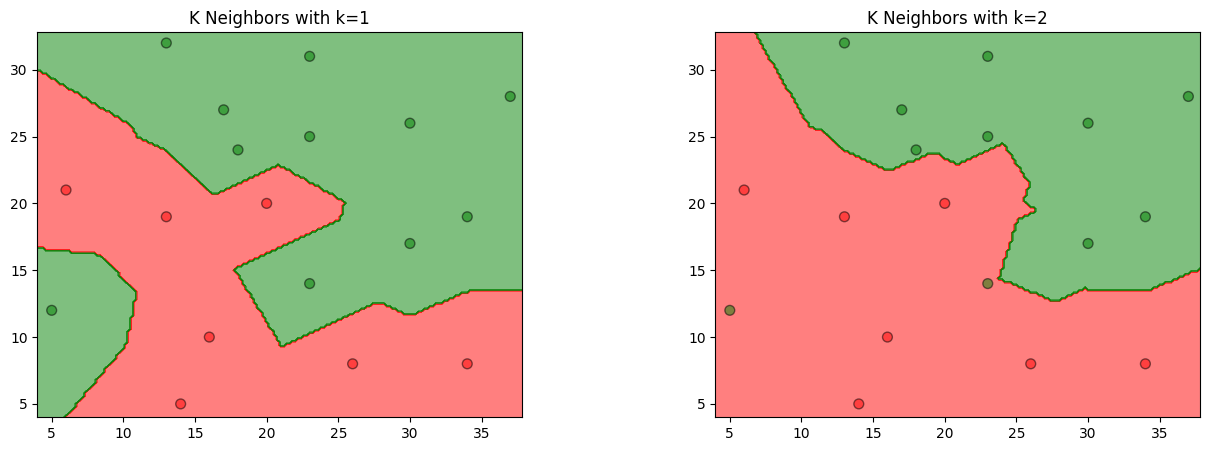

In [62]:
titles = ('K Neighbors with k=1', 'K Neighbors with k=2')   # 标题

fig = plt.figure(figsize=(15, 5)) # 创建一个图形figure，或者激活一个已经存在的图形figure；figsize:指定figure的宽和高，单位为英寸；
plt.subplots_adjust(wspace=0.4, hspace=0.4) # 调整子图的布局参数

X0, X1 = X_train[:, 0], X_train[:, 1]   # 切分0列和1列分别为X0,X1

x_min, x_max = X0.min() - 1, X0.max() + 1   # 取X0的最小值和最大值并处理，最为绘制坐标的起点和终点
y_min, y_max = X1.min() - 1, X1.max() + 1   # 取X1的最小值和最大值并处理，最为绘制坐标的起点和终点
# 生成网格点坐标矩阵
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), # 以0.2步长生成X轴序列
                     np.arange(y_min, y_max, 0.2))  # 以0.2步长生成Y轴序列

# plt.subplots(1,2),其中参数1和2分别代表子图的行数和列数，一共有 1x2 个子图像。函数返回一个figure图像和子图ax的array列表。
# flatten()是对多维数据的降维函数。
for clf, title, ax in zip(models, titles, fig.subplots(1, 2).flatten()):        
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  # 进行预测
    Z = Z.reshape(xx.shape) # 将 Z 按 xx 的形状改变
    colors = ('red', 'green', 'lightgreen', 'gray', 'cyan') # 声明颜色元组 tuple
    cmap = ListedColormap(colors[:len(np.unique(Z))])   # matplotlib.colors.ListedColormap类用于从颜色列表创建colarmap对象
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    # 填充等高线
    ax.scatter(X0, X1, c=y_train, s=50, edgecolors='k', cmap=cmap, alpha=0.5)   # 绘制散点图
    ax.set_title(title) # 绘制标题

plt.show()  # 显示所有打开的图形。

### 习题3.2
&emsp;&emsp;利用例题3.2构造的$kd$树求点$x=(3,4.5)^T$的最近邻点。

**解答：**

In [69]:
import numpy as np
from sklearn.neighbors import KDTree    # 导入sklearn k近邻法的 KDTree

train_data = np.array([(2, 3), (5, 4), (9, 6), (4, 7), (8, 1), (7, 2)]) # 声明一个数组
tree = KDTree(train_data, leaf_size=2)  # 声明一个KDTree
# d 每个条目都列出了到相应点的临近点的距离列表。
# ind 每个条目给出相应点的临近点的索引列表。
dist, ind = tree.query(np.array([(3, 4.5)]), k=1)   # 查询树中最近的k个临近点
x1 = train_data[ind[0]][0][0]
x2 = train_data[ind[0]][0][1]

print("x点的最近邻点是({0}, {1})".format(x1, x2))

x点的最近邻点是(2, 3)


### 习题3.3
&emsp;&emsp;参照算法3.3，写出输出为$x$的$k$近邻的算法。

**解答：**  
**算法：用kd树的$k$近邻搜索**  
输入：已构造的kd树；目标点$x$；    
输出：$x$的最近邻    
1. 在$kd$树中找出包含目标点$x$的叶结点：从根结点出发，递归地向下访问树。若目标点$x$当前维的坐标小于切分点的坐标，则移动到左子结点，否则移动到右子结点，直到子结点为叶结点为止；  
2. 如果“当前$k$近邻点集”元素数量小于$k$或者叶节点距离小于“当前$k$近邻点集”中最远点距离，那么将叶节点插入“当前k近邻点集”；  
3. 递归地向上回退，在每个结点进行以下操作：  
(a)如果“当前$k$近邻点集”元素数量小于$k$或者当前节点距离小于“当前$k$近邻点集”中最远点距离，那么将该节点插入“当前$k$近邻点集”。  
(b)检查另一子结点对应的区域是否与以目标点为球心、以目标点与于“当前$k$近邻点集”中最远点间的距离为半径的超球体相交。如果相交，可能在另一个子结点对应的区域内存在距目标点更近的点，移动到另一个子结点，接着，递归地进行最近邻搜索；如果不相交，向上回退；
4. 当回退到根结点时，搜索结束，最后的“当前$k$近邻点集”即为$x$的最近邻点。

In [75]:
# 构建kd树，搜索待预测点所属区域
from collections import namedtuple  # 以构造一个带字段名的 tuple
import numpy as np  


# 建立节点类
class Node(namedtuple("Node", "location left_child right_child")): # 建立节点类，字段名：节点，左子树，右子树
    def __repr__(self): # 重写实例化对象的输出信息的方法
        return str(tuple(self)) # 类型转换


# kd tree类
class KdTree():
    def __init__(self, k=1):
        self.k = k  # 保存k值
        self.kdtree = None  # 保存kdtree

    # 构建kd tree
    def _fit(self, X, depth=0):
        try:
            k = self.k  # 赋值给k
        except IndexError as e: # 用于捕获索引值是否超出了序列的有效范围
            return None
        # 这里可以展开，通过方差选择axis
        axis = depth % k    # 选择轴
        X = X[X[:, axis].argsort()] # argsort()方法是NumPy中用于获取数组排序后的索引的函数。它返回的是数组排序后的索引数组，根据排序后的索引来获取排序后的数组。
        median = X.shape[0] // 2    # //为Python中的整除除法
        try:
            X[median]   # 中位数分割点
        except IndexError:  # 用于捕获索引值是否超出了序列的有效范围
            return None
        return Node(location=X[median],     # 划分节点
                    left_child=self._fit(X[:median], depth + 1),    # 创建左子树
                    right_child=self._fit(X[median + 1:], depth + 1))   # 创建右子树

    def _search(self, point, tree=None, depth=0, best=None):
        if tree is None:    # 如果kdtree为空
            return best
        k = self.k  # 赋值给k
        # 更新 branch
        if point[0][depth % k] < tree.location[depth % k]:  # 若目标点x当前维的坐标小于切分点的坐标，则移动到左子节点
            next_branch = tree.left_child
        else:                        # 否则移动到右子节点
            next_branch = tree.right_child
        if not next_branch is None:     # 如果next_branch不为空
            best = next_branch.location # 保存next_branch的位置为最近邻
        # 递归的调用_search()
        return self._search(point,              # 输入点   
                            tree=next_branch,   # kd树节点分支
                            depth=depth + 1,    # 深度+1
                            best=best)          # 最近邻

    def fit(self, X):
        self.kdtree = self._fit(X)  # 生成kd树
        return self.kdtree          # 返回根节点

    def predict(self, X):           # 预测，即查找最近邻
        res = self._search(X, self.kdtree)  # 查找最近邻
        return res  # 返回结果，最近邻位置 .location

In [76]:
KNN = KdTree()  # 实例化kdTree
X_train = np.array([[2, 3], [5, 4], [9, 6], [4, 7], [8, 1], [7, 2]])    # 训练数据,划分超平面，用于构造平衡kdtree
KNN.fit(X_train)    # 构造kdtree
X_new = np.array([[3, 4.5]])    # 目标点
res = KNN.predict(X_new)        # 对构建好的kd树进行搜索，寻找与目标点最近的样本点

x1 = res[0]
x2 = res[1]

print("x点的最近邻点是({0}, {1})".format(x1, x2))

(6, 2)
(3, 2)
(1, 2)
(0, 2)
(0, 2)
(1, 2)
(0, 2)
(0, 2)
(2, 2)
(1, 2)
(0, 2)
(0, 2)
(0, 2)
x点的最近邻点是(2, 3)


----
参考代码：https://github.com/wzyonggege/statistical-learning-method

本文代码更新地址：https://github.com/fengdu78/lihang-code

习题解答：https://github.com/datawhalechina/statistical-learning-method-solutions-manual

中文注释制作：机器学习初学者公众号：ID:ai-start-com

配置环境：python 3.5+

代码全部测试通过。
![gongzhong](../gongzhong.jpg)